In [256]:
!pip install torch  

Mount Google Drive for access to data

In [327]:
import sys

if sys.platform == 'linux' and not 'initialized' in locals():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p data
  !google-drive-ocamlfuse data
  
  initialized = True
else:
  print("Already initialized")

Already initialized


In [0]:
import torch
import numpy as np

torch.manual_seed(1);

In [0]:
class args:
  train_size = 20000
  test_size = 10000
  
  learning_rate = 0.0005

  n_iters = 10000
  print_every = 500
  plot_every = 100

Initial boilerplate code

In [0]:
from collections import defaultdict

# Define vocabulary dictionary
next_index = 0
def get_new_index():
  global next_index
  index = next_index
  next_index += 1
  return index

vocabulary = defaultdict(get_new_index)

Load the phishing domains from a file. The file is expected to contain a pickled Python list of strings.

In [0]:
import pickle

TRAIN_FILE = "data/phishing_domains.dat"
with open(TRAIN_FILE, 'rb') as f:
    data = pickle.load(f)  

Tokenize data and fill (reverse) vocabulary

In [0]:
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(data):
  # Returns a list of Tensors, with each integer in the tensor representing a character in a domain name.
  # Note that domain names are case-insensitive.
  return [torch.tensor([vocabulary['<s>']] + [vocabulary[i] for i in domain.lower()] + [vocabulary['</s>']]).to(device) for domain in data]

def detokenize(t):
  # Recreate domain name from tensor 1d t
  res = ''
  for token in t:
    res += reverse_vocab[token.item()]
  return res

train_tokens = tokenize(data[:args.train_size])
test_tokens = tokenize(data[args.train_size:args.train_size+args.test_size])
  
vocab_size = len(vocabulary)
reverse_vocab = dict([(v,k) for k, v in vocabulary.items()])

Some helper functions

In [0]:
import numpy as np
import random

def one_hot(d):
  # One-hot encoding of 1-d tensor d
  res = torch.zeros(len(d), 1, vocab_size).to(device)
  for i, char in enumerate(d):
    res[i][0][int(char.item())] = 1
  return res

def encode_samples(d):
  # One-hot encoding for the input of a 1d tensor
  return one_hot(d[:-1])

def encode_targets(d):
  # Return targets for 1d tensor d
  return d[1:]

def random_sample(data):
  r = random.choice(data)
  return encode_samples(r), encode_targets(r)

Define model

In [0]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(RNNModel, self).__init__()              
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_input + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_input + n_hidden, n_output)
        self.o2o = nn.Linear(n_hidden + n_output, n_output)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden=None):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
      return torch.zeros(1, self.n_hidden).to(device)
    
lossfn = nn.NLLLoss()

Define train function, which trains the provided model on a single domain name

In [0]:
def train(model, samples, targets, lr):
  # train on a single example domain name
  hidden = model.init_hidden()
  targets.unsqueeze_(-1)
  
  model.zero_grad()
  
  loss = 0
    
  for i in range(samples.size(0)):    
    sample, target = samples[i], targets[i]
    output, hidden = model(sample, hidden)
    l = lossfn(output, target)
    
    loss += l

  loss.backward()
  
  for p in model.parameters():
    p.data.add(-lr, p.grad.data)
    
  return output, loss.item() / samples.size(0)   

Util function for timing

In [0]:
import time
import math

def elapsed(since):
  # Return a string representing the elapsed time since 'since'
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def now():
  return time.time()

Train the model

In [375]:
model = RNNModel(vocab_size, 128, vocab_size).to(device)

total_loss = 0  
all_losses = []
  
start = now()
  
for iter in range(1, args.n_iters+1):
  sample, target = random_sample(train_tokens)  
  output, loss = train(model, sample, target, args.learning_rate)
  total_loss += loss
  
  if iter % args.print_every == 0:
    print("%s (%d %d%%) %.4f" % (elapsed(start), iter, iter/args.n_iters*100, loss))
  
  if iter % args.plot_every == 0:
    avg_loss = total_loss / args.plot_every
    all_losses.append(avg_loss)
    total_loss = 0

tensor(215.7715, device='cuda:0', grad_fn=<ThAddBackward>)
0m 0s (1 20%) 3.7855
tensor(215.6009, device='cuda:0', grad_fn=<ThAddBackward>)
0m 0s (2 40%) 3.7825
tensor(215.6642, device='cuda:0', grad_fn=<ThAddBackward>)
0m 0s (3 60%) 3.7836
tensor(215.8185, device='cuda:0', grad_fn=<ThAddBackward>)
0m 0s (4 80%) 3.7863
tensor(215.5451, device='cuda:0', grad_fn=<ThAddBackward>)
0m 0s (5 100%) 3.7815


Text(0,0.5,'Loss')

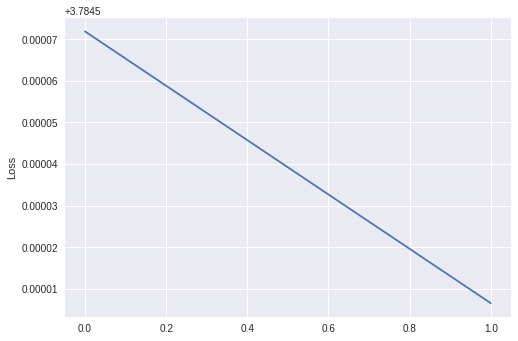

In [373]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.ylabel("Loss")